<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/Simple_Analytics_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Simple Analytics using Pyspark

## Problem Statement

Perform simple analytics with Pyspark on the real estate valuation dataset and predict the house price per unit area

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the data using pyspark
* derive the insights and visualize the data
* implement linear regression and evaluate using pyspark

### Dataset

The dataset chosen for this mini-project is **Real Estate Valuation dataset**. The data was collected from the historical market of real estate within Sindian District of New Taipei City, the timespan across 2012 August to 2013 July. In the dataset, the response variable (house price per unit area) is calculated in a local unit which is approximately $10000 New Taipei Dollar per 3.3 squared meters. For the collection of regressor data, the transaction dates are transformed into a format such that 2013.250 = 2013 March, 2013.500 = 2013 June etc. The house age was collected in years and the distance to MRT stations is measured in meters.

**Reference:**
The original owner of this Real Estate Valuation dataset is professor I-Cheng Yeh from TamKang University (Department of Civil Engineering). Prof. Yeh donated this dataset to UCI machine learning repository on 18th August 2018. The dataset can be accessed at https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set#[1].

## Grading = 10 Points

#### Install Pyspark

In [ ]:
#@title Install pyspark and Download the data
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/RealEstate.csv
print("Packages installed and dataset downloaded successfully!")

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 40.0MB/s 
Packages installed and dataset downloaded successfully!


#### Import required packages

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import MinMaxScaler
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.ml.stat import Correlation

### Data Loading (1 point)

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various spark’s functionality with a lesser number of constructs.

In [ ]:
spark = SparkSession.builder.appName('RealEstate').getOrCreate()

#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [ ]:
csv_path = "/content/RealEstate.csv"
# YOUR CODE HERE
df = spark.read.csv(csv_path, header='true', inferSchema='true')

In [ ]:
df.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [ ]:
columns = ['No', 'transaction_date','house_age','distance_to_the_nearest_MRT_station','number_of_convenience_stores','latitude','longitude','house_price_of_unit_area']
sdf = df.select(col("No").alias("No"), col("X1 transaction date").alias("transaction_date"), col("X2 house age").alias("house_age"), col("X2 house age").alias("house_age"),
                   col('X3 distance to the nearest MRT station').alias('distance_to_the_nearest_MRT_station'), col('X4 number of convenience stores').alias('number_of_convenience_stores'),
                   col('X5 latitude').alias('latitude'), col('X6 longitude').alias('longitude'), col('Y house price of unit area').alias('house_price_of_unit_area'))

sdf.show()

+---+----------------+---------+---------+-----------------------------------+----------------------------+--------+---------+------------------------+
| No|transaction_date|house_age|house_age|distance_to_the_nearest_MRT_station|number_of_convenience_stores|latitude|longitude|house_price_of_unit_area|
+---+----------------+---------+---------+-----------------------------------+----------------------------+--------+---------+------------------------+
|  1|        2012.917|     32.0|     32.0|                           84.87882|                          10|24.98298|121.54024|                    37.9|
|  2|        2012.917|     19.5|     19.5|                           306.5947|                           9|24.98034|121.53951|                    42.2|
|  3|        2013.583|     13.3|     13.3|                           561.9845|                           5|24.98746|121.54391|                    47.3|
|  4|          2013.5|     13.3|     13.3|                           561.9845|          

#### Fetch the data using handyspark

* Create a HandyFrame using handyspark `toHandy()` function

* using an instance of `cols` from your HandyFrame, you can retrieve values for given columns in the top N rows

Hint: [toHandy()](https://dvgodoy.github.io/handyspark/includeme.html)

In [ ]:
# YOUR CODE HERE
hdf = df.toHandy()
hdf.cols['X2 house age'][:10]

0    32.0
1    19.5
2    13.3
3    13.3
4     5.0
5     7.1
6    34.5
7    20.3
8    31.7
9    17.9
Name: X2 house age, dtype: float64

In [ ]:
hdf.cols[['No','X1 transaction date','X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores','X5 latitude','X6 longitude','Y house price of unit area']][:5]

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


### Deriving the insights (2 points)

#### show the no. of records per month

Hint: Apply [groupby](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.agg.html?highlight=agg#pyspark.sql.GroupedData.agg) on transaction date and count the records using aggregation `agg()`

In [ ]:
# YOUR CODE HERE
hdf.groupby('X1 transaction date').count().sort('X1 transaction date', ascending=True).show()

+-------------------+-----+
|X1 transaction date|count|
+-------------------+-----+
|           2012.667|   30|
|            2012.75|   27|
|           2012.833|   31|
|           2012.917|   38|
|             2013.0|   28|
|           2013.083|   46|
|           2013.167|   25|
|            2013.25|   32|
|           2013.333|   29|
|           2013.417|   58|
|             2013.5|   47|
|           2013.583|   23|
+-------------------+-----+



In [ ]:
sdf.groupby(sdf.transaction_date).agg({"*": "count"}).collect()

[Row(transaction_date=2012.75, count(1)=27),
 Row(transaction_date=2013.333, count(1)=29),
 Row(transaction_date=2013.083, count(1)=46),
 Row(transaction_date=2012.833, count(1)=31),
 Row(transaction_date=2013.5, count(1)=47),
 Row(transaction_date=2013.583, count(1)=23),
 Row(transaction_date=2013.417, count(1)=58),
 Row(transaction_date=2013.167, count(1)=25),
 Row(transaction_date=2013.25, count(1)=32),
 Row(transaction_date=2013.0, count(1)=28),
 Row(transaction_date=2012.917, count(1)=38),
 Row(transaction_date=2012.667, count(1)=30)]

In [ ]:
hdf.groupby('X1 transaction date').agg({"*": "count"}).sort('X1 transaction date', ascending=True).show()

+-------------------+--------+
|X1 transaction date|count(1)|
+-------------------+--------+
|           2012.667|      30|
|            2012.75|      27|
|           2012.833|      31|
|           2012.917|      38|
|             2013.0|      28|
|           2013.083|      46|
|           2013.167|      25|
|            2013.25|      32|
|           2013.333|      29|
|           2013.417|      58|
|             2013.5|      47|
|           2013.583|      23|
+-------------------+--------+



#### how much is the increase in the average house price in 2012 to 2013

Hint: Apply [filter](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html) on the transaction date and aggregate the house price using mean

In [ ]:
# YOUR CODE HERE
hdf.safety_off()
avg_price_2012 = hdf.filter(hdf['X1 transaction date'] < 2013).agg({'Y house price of unit area': 'avg'}).collect()[0][0]
avg_price_2013 = hdf.filter(hdf['X1 transaction date'] >= 2013).agg({'Y house price of unit area': 'avg'}).collect()[0][0]
price_increase = avg_price_2013 / avg_price_2012 - 1
print ("Price increase in 2013 over 2012 is {:.2%}".format(price_increase))

Price increase in 2013 over 2012 is 6.63%


In [ ]:
from pyspark.sql import functions as F
hdf.filter((hdf['X1 transaction date'] >= 2012) & (hdf['X1 transaction date'] <= 2013)).agg(F.mean(hdf['Y house price of unit area'])).show()

+-------------------------------+
|avg(Y house price of unit area)|
+-------------------------------+
|             35.350649350649356|
+-------------------------------+



#### Find the count of houses with no convenience store and show the top 10 records

In [ ]:
# YOUR CODE HERE
hdf.filter(hdf['X4 number of convenience stores'] == 0).count()

67

In [ ]:
hdf.filter(hdf['X4 number of convenience stores'] == 0).sort('Y house price of unit area', ascending=False).show(10)

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|387|           2012.833|         0.0|                              185.4296|                              0|    24.9711|    121.5317|                      55.3|
|165|           2012.833|         0.0|                              185.4296|                              0|    24.9711|    121.5317|                      55.2|
|147|            2012.75|         0.0|                              185.4296|                              0|    24.9711|    121.5317|                      52.2|
| 89|           2012.917|   

#### Compare the maximum price of houses *with convenient store* and *without convenience store*

In [ ]:
# YOUR CODE HERE
hdf.safety_off()
with_cs = hdf.filter(hdf['X4 number of convenience stores'] > 0).agg({'Y house price of unit area': 'max'}).collect()[0][0]
without_cs = hdf.filter(hdf['X4 number of convenience stores'] == 0).agg({'Y house price of unit area': 'max'}).collect()[0][0]
print("Max price of house with convenience store is {} and that without convenience store is {} ".format(with_cs, without_cs))

Max price of house with convenience store is 117.5 and that without convenience store is 55.3 


#### Decode the transaction date

* create a year column separately by removing the decimal places from transaction date column

    Hint: `withColumn()`

* create a month column separately based on the decimal places from the transaction date column

 **Hints:** multiply decimal place number with 12 and apply round off, perform below steps
     
     - use `udf()` from pyspark
     - subtracting `transaction date` from `int(transaction date)` will give the decimal place number
     - multiply the result with 12 and roundoff

To know more about udf(), click [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.udf.html?highlight=udf#pyspark.sql.functions.udf)

In [ ]:
# YOUR CODE HERE
month_udf = udf(lambda x: (x - int(x))*12)
hdf = hdf.withColumn('Year', col('X1 transaction date').cast("Int"))\
  .withColumn('Month', month_udf(col('X1 transaction date')).cast("Int"))
hdf.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|Year|Month|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|2012|   11|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|2012|   11|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391| 

### Data Visualization (2 points)

#### Select the continuous variables from the data and visualize using histogram

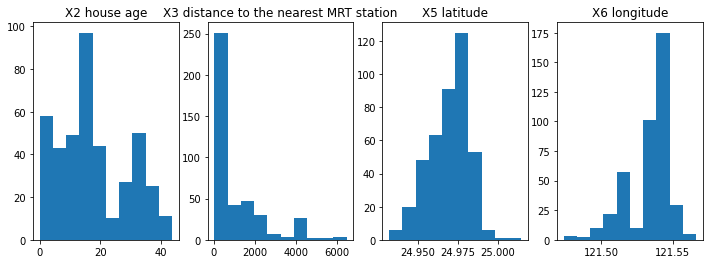

In [ ]:
# YOUR CODE HERE
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
hdf.cols['X2 house age'].hist(ax=axs[0])
hdf.cols['X3 distance to the nearest MRT station'].hist(ax=axs[1])
hdf.cols['X5 latitude'].hist(ax=axs[2])
hdf.cols['X6 longitude'].hist(ax=axs[3])

#### Visualize the transaction date using the countplot

In [ ]:
# YOUR CODE HERE
# what is the difference between histogram and count plot?

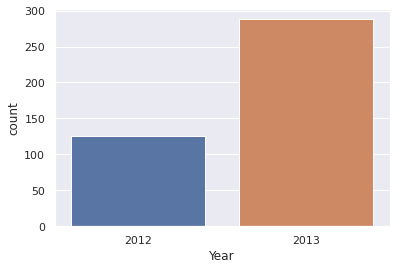

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
#fig, axs = plt.subplots(12, figsize=(12, 4))
df_pandas = hdf.toPandas()
sns.countplot(x='Year', data=df_pandas)

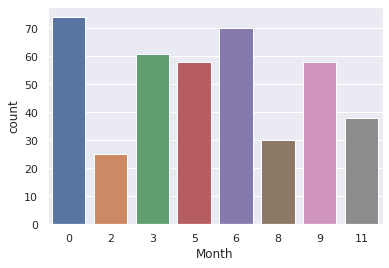

In [ ]:
sns.countplot(x='Month', data=df_pandas)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


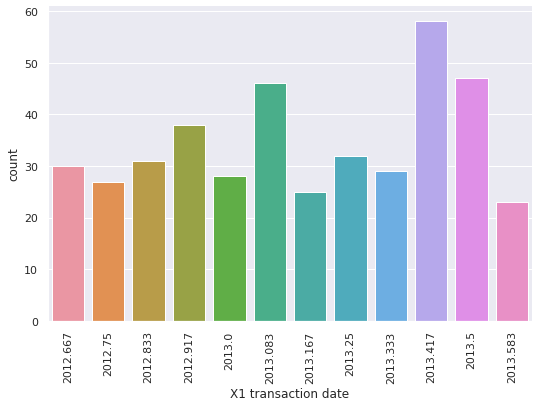

In [ ]:
ax = sns.factorplot('X1 transaction date', data=df_pandas,aspect=1.5, kind="count")
ax.set_xticklabels(rotation=90)

#### visualize number of convenience stores with appropriate plot.

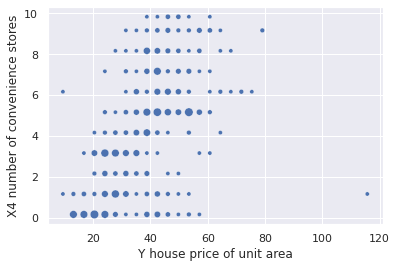

In [ ]:
# YOUR CODE HERE
hdf.cols[['Y house price of unit area','X4 number of convenience stores']].scatterplot()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


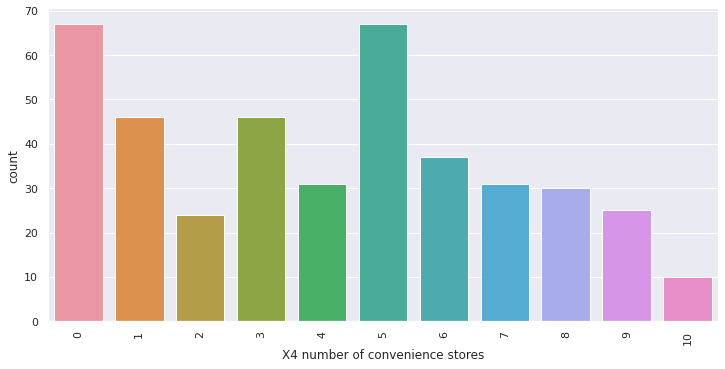

In [ ]:
ax = sns.factorplot('X4 number of convenience stores', data=df_pandas,aspect=2, kind="count")
ax.set_xticklabels(rotation=90)

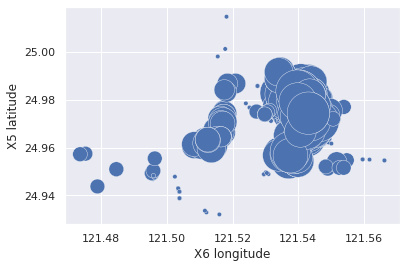

In [ ]:
#need to figure how to plot on geographical area
data = df[['X6 longitude', 'X5 latitude', 'X4 number of convenience stores']]
sns.scatterplot(data=data.toPandas(), x='X6 longitude', y='X5 latitude', size="X4 number of convenience stores", legend=False, sizes=(20, 2000))
plt.show()

In [ ]:
pip install chart-studio

     |████████████████████████████████| 71kB 3.3MB/s 


In [ ]:
import chart_studio.plotly as py
import plotly.graph_objects as go

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
data = go.Scattergeo(
        lon = df_pandas['X6 longitude'],
        lat = df_pandas['X5 latitude'],
        text = df_pandas['X4 number of convenience stores'],
        mode = 'markers',
        marker = dict(symbol = 'star',size=5,colorscale = 'Reds'
                      ),
        marker_color = df_pandas['X4 number of convenience stores'],
        )
layout = dict(title = 'Real Estate Valuation locations in Sindian District of New Taipei City',
              geo_scope = 'asia'
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

#### visualize the geographical distribution of the house prices of unit area

With:

* x-axis = X6 longitude
* y-axis = X5 latitude
* datapoints = Y house price of unit area
* parameters including size `s` and color map `cmap`

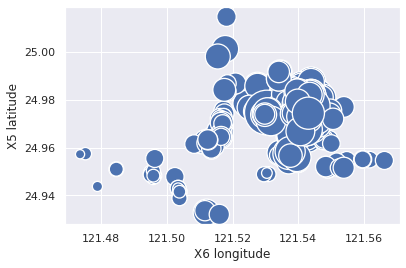

In [ ]:
# YOUR CODE HERE
data = df_pandas[['X6 longitude', 'X5 latitude', 'Y house price of unit area']]
sns.scatterplot(data=data, x='X6 longitude', y='X5 latitude', size="Y house price of unit area", legend=False, sizes=(20, 2000))
plt.show()

### Feature Scaling (1 point)

#### Identify the outliers

Use the pairplot or boxplot to identify the outliers

   **Hint:** `sns.pairplot`

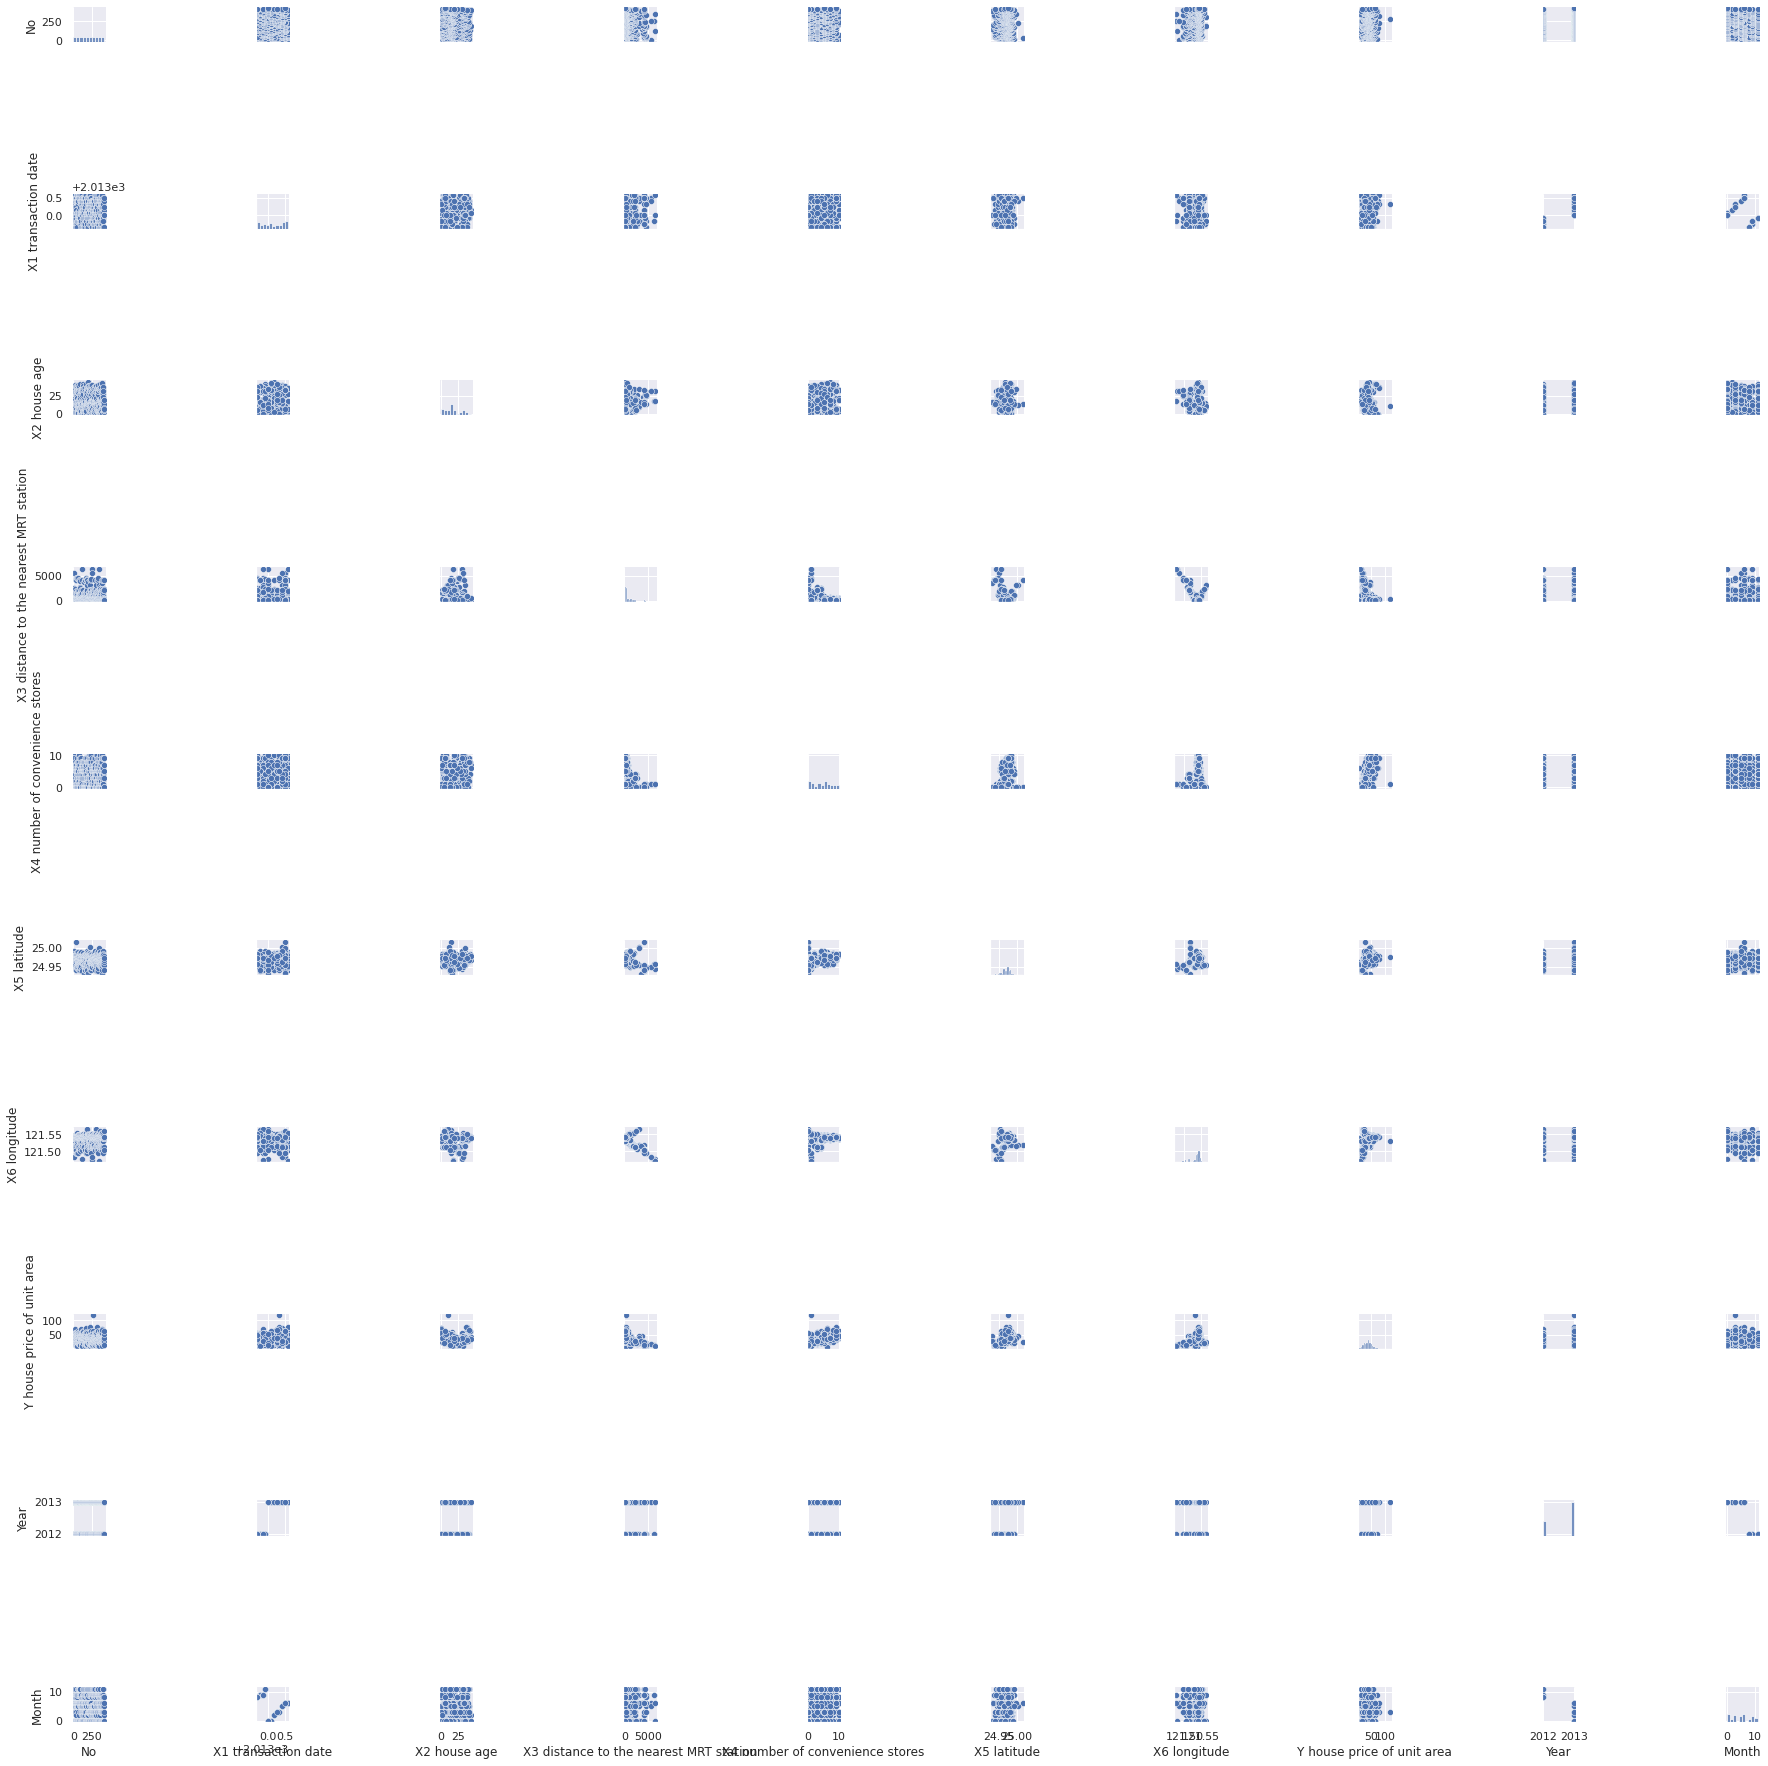

In [ ]:
# YOUR CODE HERE
sns.pairplot(df_pandas)

#### Correlation analysis

create the correlation matrix of all the columns and visualize using the heatmap

In [ ]:
# YOUR CODE HERE
vector_col = 'corr features'
column_names = ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']
assembler = VectorAssembler(inputCols=column_names, outputCol=vector_col)
df_vector = assembler.transform(hdf).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, 0.017548767356174215, 0.06087995314209749, 0.009635444586543635, 0.035057756205304484, -0.04108177780132841, 0.08749060640259809], [0.017548767356174215, 1.0, 0.025622047362740943, 0.04959251292396377, 0.054419901960116306, -0.04852005338536859, -0.21056704627721695], [0.06087995314209749, 0.025622047362740943, 1.0, -0.6025191447226254, -0.5910665729874756, -0.8063167695693758, -0.6736128553689182], [0.009635444586543635, 0.04959251292396377, -0.6025191447226254, 1.0, 0.444143305652483, 0.44909900735326885, 0.5710049111111484], [0.035057756205304484, 0.054419901960116306, -0.5910665729874756, 0.444143305652483, 1.0, 0.41292394475946775, 0.546306652503605], [-0.04108177780132841, -0.04852005338536859, -0.8063167695693758, 0.44909900735326885, 0.41292394475946775, 1.0, 0.523286507028756], [0.08749060640259809, -0.21056704627721695, -0.6736128553689182, 0.5710049111111484, 0.546306652503605, 0.523286507028756, 1.0]]


#### Normalization or standardization

select the applicable features using vector assembler and apply scaling using `MinMaxScaler` from pyspark

Hint: [MinMaxScaler](https://spark.apache.org/docs/latest/ml-features#minmaxscaler)

In [ ]:
# YOUR CODE HERE
column_names2 = ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
assembler = VectorAssembler(inputCols=column_names2, outputCol='features')
output = assembler.transform(hdf)

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("features", "scaledFeatures").show()

Features scaled to range: [0.000000, 1.000000]
+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[32.0,84.87882,10...|[0.73059360730593...|
|[19.5,306.5947,9....|[0.44520547945205...|
|[13.3,561.9845,5....|[0.30365296803652...|
|[13.3,561.9845,5....|[0.30365296803652...|
|[5.0,390.5684,5.0...|[0.11415525114155...|
|[7.1,2175.03,3.0,...|[0.16210045662100...|
|[34.5,623.4731,7....|[0.78767123287671...|
|[20.3,287.6025,6....|[0.46347031963470...|
|[31.7,5512.038,1....|[0.72374429223744...|
|[17.9,1783.18,3.0...|[0.40867579908675...|
|[34.8,405.2134,1....|[0.79452054794520...|
|[6.3,90.45606,9.0...|[0.14383561643835...|
|[13.0,492.2313,5....|[0.29680365296803...|
|[20.4,2469.645,4....|[0.46575342465753...|
|[13.2,1164.838,4....|[0.30136986301369...|
|[35.7,579.2083,2....|[0.81506849315068...|
|[0.0,292.9978,6.0...|[0.0,0.0417061177...|
|[17.7,350.8515,1....|[0.40410958904109...|
|[16.9,368.1363,8....|[0.3858

### Feature Engineering (2 points)

#### Assemble the features

concatenate all the features into a single vector which can be further passed to the ML algorithm.

**Hint:** `VectorAssembler()`

In [ ]:
# YOUR CODE HERE
# assembler = VectorAssembler(inputCols=column_names2, outputCol='features')
# output = assembler.transform(hdf)
# output.select('features', 'Y house price of unit area').show()

assembler = VectorAssembler(inputCols = column_names2, outputCol = 'features')
new_df = assembler.transform(hdf)
new_df = new_df.select(['features', 'Y house price of unit area'])
new_df.show()

+--------------------+--------------------------+
|            features|Y house price of unit area|
+--------------------+--------------------------+
|[32.0,84.87882,10...|                      37.9|
|[19.5,306.5947,9....|                      42.2|
|[13.3,561.9845,5....|                      47.3|
|[13.3,561.9845,5....|                      54.8|
|[5.0,390.5684,5.0...|                      43.1|
|[7.1,2175.03,3.0,...|                      32.1|
|[34.5,623.4731,7....|                      40.3|
|[20.3,287.6025,6....|                      46.7|
|[31.7,5512.038,1....|                      18.8|
|[17.9,1783.18,3.0...|                      22.1|
|[34.8,405.2134,1....|                      41.4|
|[6.3,90.45606,9.0...|                      58.1|
|[13.0,492.2313,5....|                      39.3|
|[20.4,2469.645,4....|                      23.8|
|[13.2,1164.838,4....|                      34.3|
|[35.7,579.2083,2....|                      50.5|
|[0.0,292.9978,6.0...|                      70.1|


#### Feature selection and splitting the data

In [ ]:
splits = new_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Train and Evaluate the model (2 points)

Using LinearRegression from `pyspark.ml` fit the data and find the coefficients and intercept

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='Y house price of unit area', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.2510346183110085,-0.004178839378108944,1.1063271431431925,218.86801903369795,4.408790691420768]
Intercept: -5958.6441159391925


Get the predictions and show the table along with actual data and predicted data

In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction",'Y house price of unit area').show(10)

test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

+------------------+--------------------------+
|        prediction|Y house price of unit area|
+------------------+--------------------------+
| 41.76402131137547|                      37.9|
| 41.76402131137547|                      52.2|
| 45.07023866243617|                      44.0|
| 49.39688240502255|                      63.3|
| 50.57166416495602|                      44.9|
|46.952586236711795|                      45.1|
|46.952586236711795|                      48.6|
| 48.97334601487364|                      51.8|
|49.110242792606186|                      49.7|
| 48.82272524388645|                      50.4|
+------------------+--------------------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 10.817


Calculate the RMSE and $R^2$ of the model

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 7.915470
r2: 0.620892
